## Dataset

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [14]:
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [15]:
print("nums of train:", len(train_data))
print("nums of test:", len(test_data))

nums of train: 60000
nums of test: 10000


In [16]:
image, label = train_data[0]
print("Shape of img:", image.shape)  # örn: torch.Size([1, 32, 32])
print("Label:", label)
print("Type:", type(image))

Shape of img: torch.Size([1, 32, 32])
Label: 5
Type: <class 'torch.Tensor'>


In [17]:
image

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

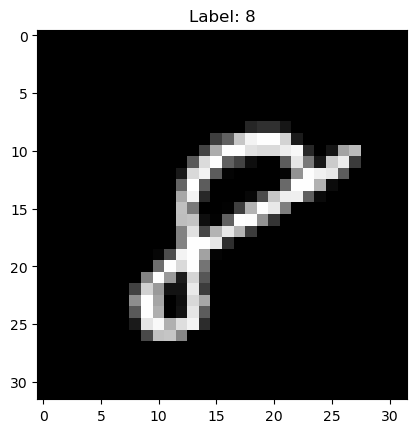

In [18]:
import matplotlib.pyplot as plt

image, label = train_data[59999]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

## Model 1

In [19]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Evrişimli Katman 1: Girdi = 1x32x32, Çıktı = 16x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)

        # Havuzlama Katmanı 1: Çıktı = 16x14x14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Evrişimli Katman 2: Çıktı = 32x10x10
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)

        # Havuzlama Katmanı 2: Çıktı = 32x5x5
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Düzleştirme Katmanı için: 32*5*5 = 800 giriş boyutu
        self.flatten = nn.Flatten()

        # Tam bağlantılı katman 1: 800 -> 120
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=120)

        # Tam bağlantılı katman 2: 120 -> 84
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        # Sınıflandırıcı katman: 84 -> 10 (10 sınıf)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Çıkış aktivasyonu
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Katman katman geçiş
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x


## Model Train on Train Dataset

In [20]:
import torch
import torch.optim as optim
model = CNN()

In [21]:
for name, param in model.named_parameters():
    print(f"Parametre adı: {name}")
    print(f"Şekli: {param.shape}")
    print(f"Değerler:\n{param}")
    print("-----------")

Parametre adı: conv1.weight
Şekli: torch.Size([16, 1, 5, 5])
Değerler:
Parameter containing:
tensor([[[[ 3.8949e-02, -1.1020e-01,  8.4110e-02,  1.5252e-01,  6.5834e-03],
          [-1.4396e-01,  1.5115e-01,  1.6572e-01, -2.2626e-02, -2.3342e-02],
          [ 1.8701e-01, -1.5637e-01, -1.9723e-01,  1.2809e-01, -5.3332e-02],
          [ 9.6261e-02,  6.1338e-02,  1.9731e-01, -1.1955e-01,  1.8505e-01],
          [-1.7634e-01,  1.2091e-01, -2.5567e-02, -6.1741e-02, -1.0289e-01]]],


        [[[-1.9502e-01,  1.0084e-01,  1.4628e-01,  7.8923e-02,  2.7523e-02],
          [-9.8745e-02, -1.9656e-01, -7.3825e-02,  1.1424e-01, -1.0462e-01],
          [ 1.9646e-01,  9.9607e-03, -6.4917e-02, -1.9366e-01,  1.3290e-01],
          [ 1.1839e-01, -3.7971e-02, -1.5112e-01, -1.2523e-01,  5.2809e-02],
          [ 4.5516e-02,  3.8695e-02, -7.5571e-02,  3.5663e-02, -6.7714e-02]]],


        [[[-1.8510e-01, -5.8922e-02, -1.9629e-01,  1.3813e-01,  1.1762e-01],
          [ 1.8855e-01, -1.0865e-01,  6.6660e-02, -1

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(2): 
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.1803
Epoch 2, Loss: 0.1021


## Model Test on Test Dataset

In [23]:
model.eval()

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 97.82%


In [24]:
correct

9782